Install Required Packages

In [1]:
## Importing required packages
import numpy as np
import nose
import matplotlib
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.feature as feat
import sklearn.preprocessing as pre
import matplotlib.patches as mpatches

from skimage.color import label2rgb, rgb2grey
from skimage.segmentation import clear_border
from os.path import join as pjoin
from scipy import ndimage as ndi
from skimage.filters.rank import mean_bilateral
from skimage.restoration import denoise_bilateral
from igor import binarywave
from skimage.morphology import disk, closing, square, opening
from skimage.filters.rank import median
from skimage.io import imshow as show
from skimage.measure import label, regionprops
from skimage.util import invert
import cv2
import pickle

In [2]:
#advanced watershed attempt
from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.util import img_as_ubyte


In [3]:
## Setting user variables for importing dataset

folder_path = 'D:/3_17_asg/3_17_asg_filtered/'


## Importing the image data from .ibw and assigning to list dat
d = {}
dat = []
for root, dirs, files in os.walk(folder_path):
    for i, name in enumerate(files):
        d = binarywave.load(root + '/' + name)
        dat.append((d['wave']['wData']))

In [4]:
## Extracting data into observables and normalizing

height = [dat[i][:,:,0] for i in range(len(dat))]
for k in range(len(height)):
    height[k] = pre.StandardScaler().fit_transform(height[k])

amp1 = [dat[i][:,:,1] for i in range(len(dat))]
for k in range(len(height)):
    amp1[k] = pre.StandardScaler().fit_transform(amp1[k])

amp2 = [dat[i][:,:,2] for i in range(len(dat))]
for k in range(len(height)):
    amp2[k] = pre.StandardScaler().fit_transform(amp2[k])

phase1 = [dat[i][:,:,3] for i in range(len(dat))]
for k in range(len(height)):
    phase1[k] = pre.StandardScaler().fit_transform(phase1[k])

phase2 = [dat[i][:,:,4] for i in range(len(dat))]
for k in range(len(height)):
    phase2[k] = pre.StandardScaler().fit_transform(phase2[k])


In [5]:
## Registering data via translation from the regist data set

regist = height[0]

translation =[feat.register_translation((regist),(height[i]))[0] for i in range(len(height))]

for k in range(len(height)):
    height[k] = np.roll(height[k], (int(translation[k][0]),int(translation[k][1])), (0,1))
    amp1[k] = np.roll(amp1[k], (int(translation[k][0]),int(translation[k][1])), (0,1))
    amp2[k] =np.roll(amp2[k], (int(translation[k][0]),int(translation[k][1])), (0,1))
    phase1[k] = np.roll(phase1[k], (int(translation[k][0]),int(translation[k][1])), (0,1))
    phase2[k] = np.roll(phase2[k], (int(translation[k][0]),int(translation[k][1])), (0,1))

In [6]:
## Moving the array by the maximum positive or negative translations
translation_np = np.array(translation)
type(translation_np)
pos = np.max(translation_np, axis = 0)
neg = np.min(translation_np, axis = 0)

chop = [0,0]
for i in range(2):
    
    if abs(pos[i]) > abs(neg[i]):
        chop[i] = int(pos[i])
    else:
        chop[i] = int(neg[i])

        dat = [height, amp1, amp2, phase1, phase2]

for i in range(len(height)):
    for k in range(5):
        if chop[0] >= 0 and chop[1] >= 0:
            dat[k][i] = dat[k][i][(chop[0]):,(chop[1]):]
        
        elif chop[0] >= 0 and chop[1] < 0:
            dat[k][i] = dat[k][i][(chop[0]):,:(chop[1])]
        
        elif chop[0] < 0 and chop[1] >= 0:
            dat[k][i] = dat[k][i][:(chop[0]),(chop[1]):]
        
        else:
            dat[k][i] = dat[k][i][:(chop[0]),:(chop[1])]

height = dat[0]
amp1 = dat[1]
amp2 = dat[2]
phase1 = dat[3]
phase2 = dat[4]

In [7]:
def scale_series (images):
    maxes = np.empty((len(images),1),dtype=float)
    for i,image in enumerate(images):
        maxes[i] = np.array(np.amax(image))
    scales = np.amax(maxes)
    out = [image/scales for image in images] 
    return out

In [8]:
scaled_amp1 = scale_series(amp1)
scaled_amp2 = scale_series(amp2)
scaled_phase1 = scale_series(phase1)
scaled_phase2 = scale_series(phase2)
scaled_height = scale_series(height)

In [9]:
amp2_fin[1].shape

NameError: name 'amp2_fin' is not defined

In [10]:
amp1_plt = flip_trans(amp1)
amp2_plt= flip_trans(amp2)
height_plt = flip_trans(height)
phase1_plt = flip_trans(phase1)
phase2_plt = flip_trans(phase2)
plt.imshow(phase2_plt[0])

NameError: name 'flip_trans' is not defined

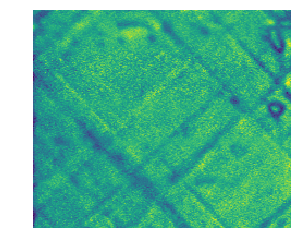

In [35]:

for i, image in enumerate(amp2_plt):
    plt.imshow(image)
    plt.axis('off')
    plt.savefig("D:/switching study/figures/ag/"+ "amp2"+ str(i))
    plt.close

C:\Users\Josh_\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


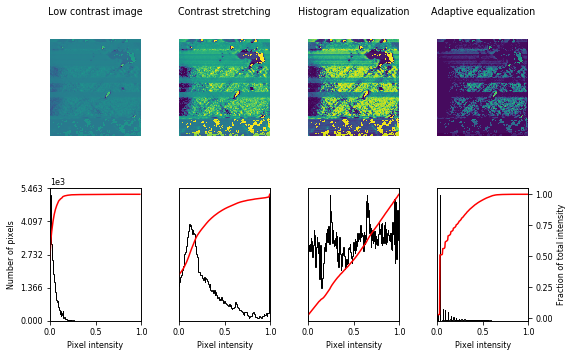

In [11]:
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    #image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.viridis)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = np.flipud(scaled_phase1[24].T)

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [12]:
#function used to sharpen the contrast of the images
def contrast_sharpen (image):
    for i in range(len(image)):
        p2, p98 = np.percentile(image[i], (2, 98))
        image[i] = exposure.rescale_intensity(image[i], in_range=(p2, p98))
    return image


In [13]:
# Sharpening the contrast on all images in the data set
cs_amp1 = contrast_sharpen(scaled_amp1)
cs_amp2 = contrast_sharpen(scaled_amp2)
cs_height = contrast_sharpen(scaled_height)
cs_phase1 = contrast_sharpen(scaled_phase1)
cs_phase2 = contrast_sharpen(scaled_phase2)

In [14]:
# defining function to flip and transpose the array
def flip_trans (image):
    for i in range(len(image)):
        image[i] = np.flipud(image[i].T)
        image[i] = image[i][:200,:]
    return image

In [15]:
# fliping the data and transposing it in order to match orientation to asylum analysis
amp1_fin = flip_trans(cs_amp1)
amp2_fin = flip_trans(cs_amp2)
height_fin = flip_trans(cs_height)
phase1_fin = flip_trans(cs_phase1)
phase2_fin = flip_trans(cs_phase2)

In [16]:
phase1_fin[1].shape

(200, 237)

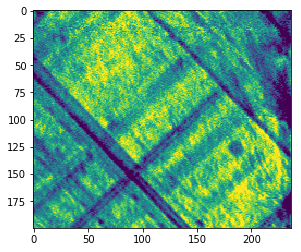

In [17]:
## plotting an example image
%matplotlib inline
ax = plt.imshow(amp1_fin[0])
#ax.set_clim(-4.5,4.5)
#plt.savefig('D:/Layerwise/' + 'raw', format='pdf', dpi=300)

In [36]:
np.save('prepull_ag', amp1_fin[0])

In [18]:
im = amp2_fin[0]
im = img_as_ubyte(im)
for i in range(len(im[:,1]-1)):
    for k in range(len(im[1]-1)):
        if im[i,k] ==255:
            im[i,k] = im[i,k]-1

C:\Users\Josh_\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [19]:

def draw_lines(event,x,y,flags,param):
    global ix, iy, drawing
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x,y
    
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.line(im,(ix,iy),(x,y),(255),2)

In [ ]:
cv2.namedWindow('image')
cv2.setMouseCallback('image',draw_lines)

while(1):
    cv2.imshow('image',im)
    k = cv2.waitKey(1) 
    if k == 27:
        break
cv2.destroyAllWindows()

In [26]:
cv2.imshow('image',im)
cv2.waitKey(0)
cv2.destroyAllWindows()

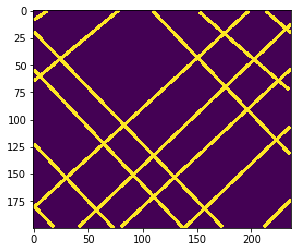

In [27]:
mask = im == 255

plt.imshow(mask)

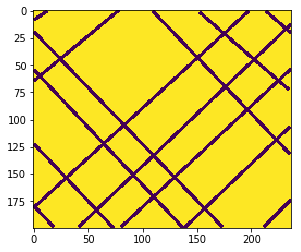

In [28]:
dist = np.logical_not(mask)
plt.imshow(dist)

In [29]:
distance_array = ndi.morphology.distance_transform_edt(dist)

In [40]:
np.save("distance_ag",distance_array)

In [30]:
with open("asgrown_dist.txt", "wb") as fp:   #Pickling
    pickle.dump(distance_array, fp)
 
with open("asgrown_dist.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

b.shape


(200, 237)

In [34]:
for n,image in enumerate(phase1_fin):
    plt.hist(image.reshape(-1))
    plt.savefig("D:/switching study/doped_hist/hist_doped" + str(n))
    plt.close()

In [15]:
im2 = phase1_fin

switch_high = [ im2[i]>0.7 for i in range(len(im2))]
switch_low = [ im2[i]<-0.4 for i in range(len(im2))]
switch = [switch_high[i]+switch_low[i] for i in range(len(im2))]
bilat = [mean_bilateral(switch[i].astype(np.uint16), disk(1)) for i in range(len(switch))]

bw = [closing(bilat[i], square(3)) for i in range(len(bilat))]

label_img = [label(bilat[i]) for i in range(len(bilat))]


In [16]:
import pickle

with open("ag_bilat.txt", "wb") as fp:   #Pickling
    pickle.dump(bilat, fp)
 
with open("ag_bilat.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

len(b)

39

In [147]:
regions = []
region17 = []
region18 = []
region19 = []
region20 = []
region21 = []
region22 = []
region23 = []
region24 = []
region25 = []
region26 = []
region27 = []
region28 = []
region29 = []
region30 = []
region31 = []
region32 = []
region33 = []
region34 = []
region35 = []
region36 = []
region37 = []
region38 = []

for region in regionprops (label_img[17]):
     # take regions with large enough areas
    if region.area >= 8.0 and (30<region.centroid[0]<50 or 125<region.centroid[0]<150) and region.centroid[1]>145:
        region17.append(region)
regions.append(region17)

for region in regionprops (label_img[18]):
     # take regions with large enough areas
    if region.area >= 8.0 and (30<region.centroid[0]<50 or 125<region.centroid[0]<150) and region.centroid[1]>145:
        region18.append(region)
regions.append(region18)

for region in regionprops (label_img[19]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<20 or 30<region.centroid[0]<50 or 125<region.centroid[0]<150) and region.centroid[1]>145:
        region19.append(region)
regions.append(region19)

for region in regionprops (label_img[20]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<20 or 30<region.centroid[0]<50 or 125<region.centroid[0]<150) and region.centroid[1]>145:
        region20.append(region)
regions.append(region20)
            
for region in regionprops (label_img[21]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<20 or 30<region.centroid[0]<60 or 125<region.centroid[0]<150) and region.centroid[1]>50:
        region21.append(region)
regions.append(region21)
                                   
for region in regionprops (label_img[22]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<20 or 30<region.centroid[0]<60 or 120<region.centroid[0]<150) and region.centroid[1]>30:
        region22.append(region)
regions.append(region22)
                                   
for region in regionprops (label_img[23]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<25 or 30<region.centroid[0]<70 or 120<region.centroid[0]) and region.centroid[1]>30:
        region23.append(region)
regions.append(region23)

for region in regionprops (label_img[24]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<25 or 30<region.centroid[0]<70 or 120<region.centroid[0]) and region.centroid[1]>30:
        region24.append(region)
regions.append(region24)

for region in regionprops (label_img[25]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<25 or 30<region.centroid[0]<70 or 120<region.centroid[0]) and region.centroid[1]>25:
        region25.append(region)
regions.append(region25)
                                   
for region in regionprops (label_img[26]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<80 or (region.centroid[0]>80 and region.centroid[1]>25)):
        region26.append(region)
regions.append(region26)

for region in regionprops (label_img[27]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<80 or (region.centroid[0]>80 and region.centroid[1]>25)):
        region27.append(region)
regions.append(region27)

for region in regionprops (label_img[28]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<100 or (region.centroid[0]>100 and region.centroid[1]>25)):
        region28.append(region)
regions.append(region28)

for region in regionprops (label_img[29]):
     # take regions with large enough areas
    if region.area >= 8.0 and (region.centroid[0]<100 or (region.centroid[0]>100 and region.centroid[1]>25)):
        region29.append(region)
regions.append(region29)


im2 = phase1_fin

switch_high = [ im2[i]>0.2 for i in range(len(im2))]
switch_low = [ im2[i]<-0.4 for i in range(len(im2))]
switch = [switch_high[i]+switch_low[i] for i in range(len(im2))]
bilat = [mean_bilateral(switch[i].astype(np.uint16), disk(1)) for i in range(len(switch))]


bw = [closing(bilat[i], square(3)) for i in range(len(bilat))]
label_img = [label(bilat[i]) for i in range(len(bilat))]

for region in regionprops (label_img[30]):
     # take regions with large enough areas
    if (region.area >= 8.0 and 20<region.centroid[0]<125 and region.centroid[1]>150) or region.area>100:
        region30.append(region)
regions.append(region30)

for region in regionprops (label_img[31]):
     # take regions with large enough areas
    if (region.area >= 8.0 and 15<region.centroid[0]<125 and region.centroid[1]>150) or region.area>100:
        region31.append(region)
regions.append(region31)

for region in regionprops (label_img[32]):
     # take regions with large enough areas
    if (region.area >= 8.0 and 15<region.centroid[0]<125 and region.centroid[1]>150) or region.area>50:
        region32.append(region)
regions.append(region32)

for region in regionprops (label_img[33]):
     # take regions with large enough areas
    if (region.area >= 8.0 and 15<region.centroid[0]<125 and region.centroid[1]>150) or region.area>50:
        region33.append(region)
regions.append(region33)

im2 = phase1_fin

switch_high = [ im2[i]>0.3 for i in range(len(im2))]
switch_low = [ im2[i]<-0.2 for i in range(len(im2))]
switch = [switch_high[i]+switch_low[i] for i in range(len(im2))]
bilat = [mean_bilateral(switch[i].astype(np.uint16), disk(1)) for i in range(len(switch))]

for region in regionprops (label_img[34]):
     # take regions with large enough areas
    if (region.area >= 8.0 and 15<region.centroid[0]<125 and region.centroid[1]>150) or region.area>50:
        region34.append(region)
regions.append(region34)

for region in regionprops (label_img[35]):
     # take regions with large enough areas
    if (region.area >= 8.0 and 10<region.centroid[0]<125 and region.centroid[1]>150) or region.area>50:
        region35.append(region)
regions.append(region35)

for region in regionprops (label_img[36]):
     # take regions with large enough areas
    if (region.area >= 8.0 and region.centroid[0]<125 and region.centroid[1]>150) or region.area>50:
        region36.append(region)
regions.append(region36)

for region in regionprops (label_img[37]):
     # take regions with large enough areas
    if (region.area >= 8.0 and region.centroid[0]<125 and region.centroid[1]>150) or region.area>50:
        region37.append(region)
regions.append(region37)

for region in regionprops (label_img[38]):
     # take regions with large enough areas
    if (region.area >= 8.0 and region.centroid[0]<125 and region.centroid[1]>150) or region.area>50:
        region38.append(region)
regions.append(region38)


(array([  405.,   894.,  1445.,  1137.,   368.,   118.,    35.,  2042.,
         1178.,   673.]),
 array([-0.84931004, -0.66437904, -0.47944803, -0.29451703, -0.10958602,
         0.07534498,  0.26027598,  0.44520699,  0.63013799,  0.815069  ,  1.        ]),
 <a list of 10 Patch objects>)

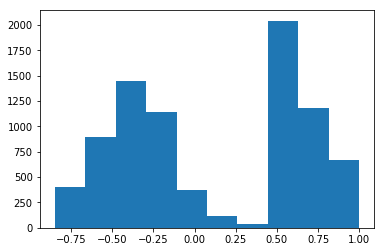

In [145]:
plt.hist(phase1_fin[36][125:160,:].reshape(-1))

In [148]:
image_label_overlay = [label2rgb(label_img[i], bg_color =(0,0,0)) for i in range(len(label_img))]
image_label_overlay = [rgb2grey(image_label_overlay[i]) for i in range(len(label_img))]

In [149]:
for i in range(22):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
    ax1.imshow(phase1_fin[i+17])
    
    ax2.imshow(image_label_overlay[i+17])
    
    for region in regions[i]:
    # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='r', linewidth=2)
        ax2.add_patch(rect)
    ax3.imshow(bilat[i+17])
    
    plt.tight_layout()
    plt.savefig("D:/switching study/combination" + str(i+17), format="png", dpi=300)
    plt.close()

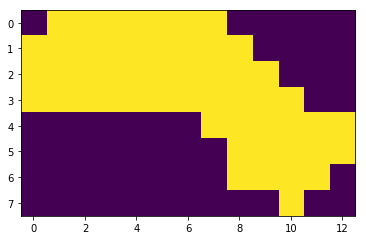

In [200]:
# Deleted Regions 13 2:3, 14 2:3, 15 1+3, 16 1+3


In [204]:
import pickle

with open("asgrown.txt", "wb") as fp:   #Pickling
    pickle.dump(regions, fp)
 
with open("asgrown.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

len(b)


22

In [150]:
nucleation = []
for image in regions:
    nucleation.append(len(image))

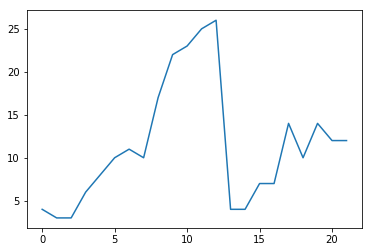

In [151]:
plt.plot(nucleation)

In [ ]:
distance = [distance_array[(int(round_center[i][0]),int(round_center[i][1]))] for i in range(len(round_center))]

In [ ]:
rounded_distance = [round(distance[i]) for i in range(len(distance))]
rounded_distance
fig, ax = plt.subplots(1,2, figsize=(10,15), sharex=False, sharey=False)
ax[0] = plt.hist(rounded_distance, bins= 20)
ax[1] = plt.hist(rounded_distance, bins= 30)

In [ ]:
h = [regionprops(label_img[i]) for i in range(len(label_img))]

In [ ]:
center =np.empty((55,480,2),dtype=float)
for i in range(len(h)):
    for k in range(len(h[i])):
        center[i][k][0]=(h[i][k].centroid[0])
        center[i][k][1]=(h[i][k].centroid[1])

In [ ]:
round_center = np.around(center)
round_int = round_center.astype(int)

In [ ]:
distance = np.empty((55,480,1), dtype=float)
for i in range(len(h)):
    for k in range(len(h[i])):
        distance[i][k] = distance_array[round_int[i][k][0],round_int[i][k][1]]
        
rounded_distance = np.around(distance)

In [ ]:
a = [plt.hist(rounded_distance[i].reshape(-1),bins=50) for i in range(len(h))]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

In [ ]:
a[1][1]

In [ ]:
np.cumsum(np.diff(a[1][1]))

In [ ]:
for i in range(len(h)):
    y = np.cumsum(np.diff(a[i][1]))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(h)):
    for k in range(len(h[i])):
        ax.scatter(y,10*i,a[i][0])
ax.set_zlim(0,40)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    for k in range(len(h[i])):
        ax.bar(a[i][1][:50],a[i][0],zdir='y')

plt.show()

In [ ]:
h= regionprops(label_img)
center = [h[i].centroid for i in range(len(h))]
round_center = np.zeros((len(h),2))
for i in range(len(center)):
    for k in range(2):
        round_center[i][k] = round(center[i][k])

In [142]:
import itertools
for item in itertools.chain(listone, listtwo):
   # do something with each list item

In [ ]:
fig = plt.figure(frameon=False)
z1 = plt.imshow(bilat[4], cmap=plt.cm.gray)
z2 = plt.imshow(markers, cmap=plt.cm.spectral, alpha = .5)
z3 = plt.plot(regions[4][15].centroid, marker="x", color="r")

In [ ]:
dist = ndi.morphology.distance_transform_edt(markers)


In [ ]:
### Exporting images for movies 
#for k in range(len(bilat)):
#    ax= plt.imshow(bilat[k])
#    plt.savefig('D:/videos/bilat/bilat' + str(k), format='png', dpi=200)
#    plt.close()

In [ ]:
mask = im2[0]>0.2
plt.imshow(mask)

In [ ]:
#for i in range(len(bilat)):
#    fig = plt.figure(frameon=False)
#    z1 = plt.imshow(bilat[i], cmap=plt.cm.gray)
#    z2 = plt.imshow(markers, cmap=plt.cm.spectral, alpha = .5)
#    plt.savefig('D:/videos/comp/comp' + str(i), format='png', dpi=200)
#    plt.close()

In [ ]:
mask = [amp1[1] < (-1-(i/10)) for i in range(9)]

In [ ]:
markers = np.zeros_like(amp1[1])
markers[amp1[1] < -1] = 2
markers[amp1[1] > 2] = 1

In [ ]:
im = amp1[1]/np.max(abs(amp1[1]))

In [ ]:
# initial attempt at watershed
from skimage.filters import sobel
elevation_map = sobel(im)

plt.imshow(elevation_map)


In [ ]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(3,3,1)
ax1.imshow(mask[0])

ax2 = fig.add_subplot(3,3,2)
ax2.imshow(mask[1])


ax3 = fig.add_subplot(3,3,3)
ax3.imshow(mask[2])

ax4 = fig.add_subplot(3,3,4)
ax4.imshow(mask[3])

ax5 = fig.add_subplot(3,3,5)
ax5.imshow(mask[4])

ax6 = fig.add_subplot(3,3,6)
ax6.imshow(mask[5])

ax7 = fig.add_subplot(3,3,7)
ax7.imshow(mask[6])

ax8 = fig.add_subplot(3,3,8)
ax8.imshow(mask[7])

ax9 = fig.add_subplot(3,3,9)
ax9.imshow(mask[8])

In [ ]:
from skimage.restoration import denoise_tv_chambolle

In [ ]:
denoise = [denoise_tv_chambolle(mask[i],weight=0.1,eps=0.0002, multichannel=False) for i in range(len(mask))]

In [ ]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(3,3,1)
ax1.imshow(denoise[0])

ax2 = fig.add_subplot(3,3,2)
ax2.imshow(denoise[1])


ax3 = fig.add_subplot(3,3,3)
ax3.imshow(denoise[2])

ax4 = fig.add_subplot(3,3,4)
ax4.imshow(denoise[3])

ax5 = fig.add_subplot(3,3,5)
ax5.imshow(denoise[4])

ax6 = fig.add_subplot(3,3,6)
ax6.imshow(denoise[5])

ax7 = fig.add_subplot(3,3,7)
ax7.imshow(denoise[6])

ax8 = fig.add_subplot(3,3,8)
ax8.imshow(denoise[7])

ax9 = fig.add_subplot(3,3,9)
ax9.imshow(denoise[8])

In [ ]:
## Exporting images for movies 
for i in range(5):
    for k in range(len(height)):
        ax =plt.imshow(np.flipud(dat[i][k].T))
        ax.set_clim(-1.5,1.5)
        if i == 0:
            plt.savefig('D:/doped_10_14/videos/height' + str(k), format='png', dpi=900)
            
        elif i == 1:
            plt.savefig('D:/doped_10_14/videos/amp1' + str(k), format='png', dpi=900)
        
        elif i == 2:
            plt.savefig('D:/doped_10_14/videos/amp2' + str(k), format='png', dpi=900)
            
        elif i == 3:
            plt.savefig('D:/doped_10_14/videos/phase1' + str(k), format='png', dpi=900)
            
        else:
            plt.savefig('D:/doped_10_14/videos/phase2' + str(k), format='png', dpi=900)
        plt.close()

In [ ]:
from skimage.feature import shape_index as si

In [ ]:
#image = phase1[20]/np.max(abs(phase1[20]))
#
#s = si(image)
#delta = 0.05
#
#cap_y, cap_x = np.where(np.abs(s-(7/8))<delta)
#dome_y, dome_x = np.where(np.abs(s-(5/8))<delta)
#rut_y, rut_x = np.where(np.abs(s-(3/8))<delta)
#sadrut_y, sadrut_x = np.where(np.abs(s-(1/8))<delta)
#saddle_y, saddle_x = np.where(np.abs(s)<0.3)
#
#scatter_settings = dict(alpha = 0.75, s=10, linewidths=0)


#fig=plt.figure(figsize=(15,15))
#
#ax1 = fig.add_subplot(2, 3, 1)                
#ax1.imshow(s, cmap=plt.cm.gray)
#
#ax2 = fig.add_subplot(2,3,2)
#ax2.imshow(image)
#ax2.scatter(cap_x, cap_y, color = "red", **scatter_settings)
#
#ax3 = fig.add_subplot(2,3,3)
#ax3.imshow(image)
#ax3.scatter(dome_y, dome_x, color = "red", **scatter_settings)
#
#ax4 = fig.add_subplot(2,3,4)
#ax4.imshow(image)
#ax4.scatter(rut_y, rut_x, color="red", **scatter_settings)
#
#ax5 = fig.add_subplot(2,3,5)
#ax5.imshow(image)
#ax5.scatter(sadrut_y, sadrut_x, color="red", **scatter_settings)
#
#ax6 = fig.add_subplot(2,3,6)
#ax6.imshow(image)
#ax6.scatter(saddle_y, saddle_x, color="red", **scatter_settings)
#

In [ ]:
img = np.flipud((amp1[2]/np.max(abs(amp1[2]))).T)


In [ ]:
plt.hist(img.reshape(-1))

In [ ]:
## playing with canny edge detectors
from scipy import ndimage as ndi

from skimage import feature

im = mask[0]

# compute the cany filter for two values of sigma
edges1 = feature.canny(im, sigma=.13)
edges2 = feature.canny(im, sigma=2)

#Display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,15),
                                    sharex=True, sharey=True)

ax1.imshow(im)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

In [ ]:
plt.imshow(amp1[2])

In [ ]:
plt.hist(amp1[2].reshape(-1))

In [ ]:
## Testing various filters
import skimage.filters as filt

image = img

otsu = [filt.threshold_otsu(image[i]) for i in range(len(image))]

#mi = [filt.threshold_minimum(image[i]) for i in range(len(image))]

tri = [filt.threshold_triangle(image[i]) for i in range(len(image))]

yen = [filt.threshold_yen(image[i]) for i in range(len(image))]

In [ ]:
from skimage.filters import try_all_threshold
from skimage.util import invert
im = img
img = invert(im)
# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(25, 25), verbose=False)
plt.savefig('D:/Layerwise/' + 'fer_el', format='pdf', dpi=300)

In [ ]:
yen = [filt.threshold_yen(img[i]) for i in range(len(img))]
binary = [img[i] > yen[1] for i in range(len(img))]

plt.imshow((binary))
#plt.savefig("D:/Layerwise")

In [ ]:
img = np.array(binary)

bilat = mean_bilateral(img.astype(np.uint16), disk(2), s0=10, s1=10)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex='row', sharey='row')
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(bilat, cmap=plt.cm.gray)
ax[1].set_title('Bilateral mean')

ax[2].imshow(img[200:350, 350:400], cmap=plt.cm.gray)

ax[3].imshow(bilat[200:350, 350:400], cmap=plt.cm.gray)

for a in ax:
    a.axis('off')
    a.set_adjustable('box-forced')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title('Noisy image')

ax[1].imshow(median(img, disk(1)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('Median $r=1$')

ax[2].imshow(median(img, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('Median $r=5$')

ax[3].imshow(median(img, disk(20)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('Median $r=20$')

for a in ax:
    a.axis('off')
    a.set_adjustable('box-forced')

In [ ]:
## masking the images at a given filter value
binary = [image[i] > yen[1] for i in range(len(amp1))]

In [ ]:
## Exporting the masked images for movie making.
for i in range(len(amp1)):
    ax = plt.imshow(np.flipud(binary[i].T))
    ax.set_clim(-1.5,1.5)
    plt.savefig('C:/Users/Josh_/Downloads/Images/yen' + str(i))

In [ ]:
print(np.amax(amp1[2]))
print(np.amin(amp1[2]))


In [ ]:
## playing with canny edge detectors
from scipy import ndimage as ndi

from skimage import feature

im = img

# compute the cany filter for two values of sigma
edges1 = feature.canny(im, low_threshold=0.1)
edges2 = feature.canny(im, sigma=5)

#Display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

In [ ]:
img = img/(np.amax(abs(img)))
plt.hist(img.reshape(-1))

(array([  1913.,   1749.,   2923.,   4463.,   7404.,  10145.,   8388.,
          5606.,   2709.,   2055.]),
 array([ -1.00000000e+00,  -7.99999976e-01,  -5.99999952e-01,
         -3.99999928e-01,  -1.99999905e-01,   1.19209290e-07,
          2.00000143e-01,   4.00000167e-01,   6.00000191e-01,
          8.00000215e-01,   1.00000024e+00]),
 <a list of 10 Patch objects>)

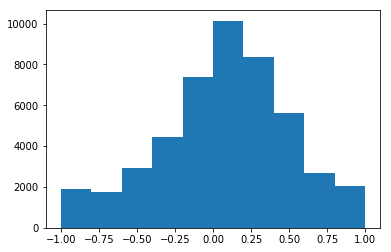

In [53]:
plt.hist(scaled_phase1[7].reshape(-1))

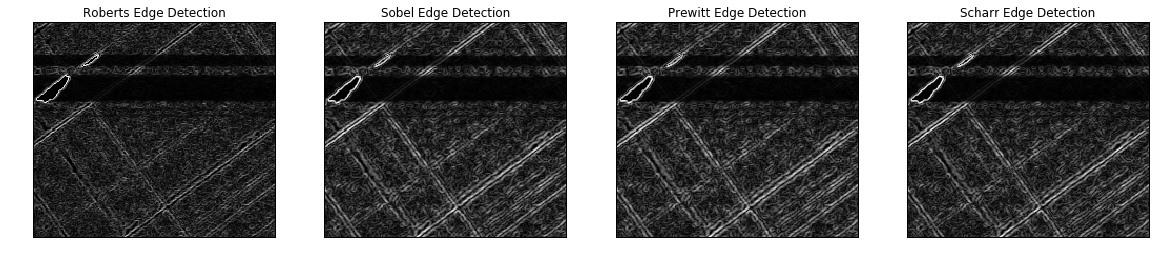

In [54]:
from skimage.filters import roberts, sobel, scharr, prewitt

img = scaled_phase1[8]
edge_roberts = roberts(img)
edge_sobel = sobel(img)
edge_prewitt = prewitt(img)
edge_scharr = scharr(img)

fig, ax = plt.subplots(ncols=4,
                       figsize=(20,20))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

ax[2].imshow(edge_prewitt, cmap=plt.cm.gray)
ax[2].set_title('Prewitt Edge Detection')

ax[3].imshow(edge_scharr, cmap=plt.cm.gray)
ax[3].set_title('Scharr Edge Detection')
for a in ax:
    a.axis('off')

plt.show()

(array([  2.26780000e+04,   1.60820000e+04,   6.14700000e+03,
          1.62500000e+03,   4.91000000e+02,   1.61000000e+02,
          6.10000000e+01,   7.10000000e+01,   1.00000000e+01,
          2.90000000e+01]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

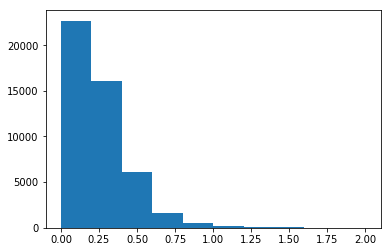

In [55]:
plt.hist(edge_roberts.reshape(-1))

In [ ]:
# Applying an edge operator to the entire data set to export to a movie

#for i in range(len(amp1)):
  #  if abs(np.amax(amp1[i])) > abs(np.amin(amp1[i])):
   #     edgy =((amp1[i])/(np.amax(amp1[i])))
 #   else:
      #  edgy = ((ampl[i])/(abs(np.amin(ampl[i]))))

edge_prewitt = prewitt(img_rescale)
ax = plt.imshow(np.flipud(edge_prewitt.T), cmap=plt.cm.gray)
  #  plt.savefig('C:/Users/Josh_/Downloads/Images/sobel' + str(i))


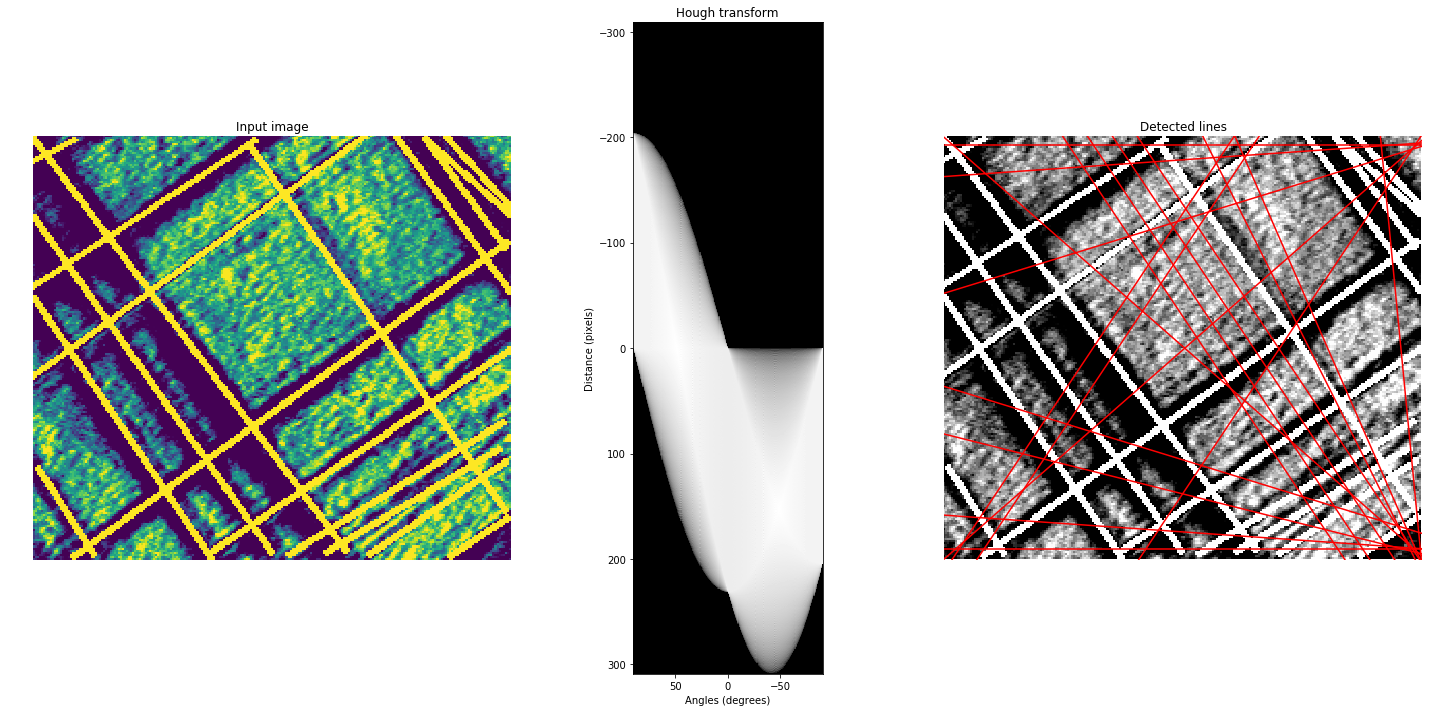

In [48]:
from skimage.transform import (hough_line, hough_line_peaks,
                              probabilistic_hough_line)

h, theta, d = hough_line(scaled_phase1[6])

fig, axes = plt.subplots(1, 3, figsize =(20,10), subplot_kw={'adjustable': 'box-forced'})

ax = axes.ravel()

ax[0].imshow(im)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(im, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - im.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, im.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, im.shape[1]))
ax[2].set_ylim((im.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

In [ ]:

from skimage.feature import canny
edges = canny(im_eq, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(amp1[3], cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, amp1[3].shape[1]))
ax[2].set_ylim((amp1[3].shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()
    a.set_adjustable('box-forced')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib
from skimage import img_as_float
from skimage import exposure



scaled_im = amp1[3]/(np.max(abs(amp1[3])))
                     
def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = amp1[3]

# Contrast stretching
p2, p98 = np.percentile(img, (5, 95))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
#img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(25, 15))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

#ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
#ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [ ]:
np.max(img)

In [ ]:
from skimage.filters import try_all_threshold
from skimage.util import invert
img = im
im =amp1[1]
img = invert(im)
# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(25, 25), verbose=False)
plt.savefig('D:/Layerwise/' + 'fer_el', format='pdf', dpi=300)

In [ ]:
plt.hist(amp1[3].reshape(-1))

In [ ]:
np.var(amp1[3])